In [23]:
%cd drive/MyDrive/Colab\ Notebooks

/content/drive/MyDrive/Colab Notebooks


In [24]:
import os
import torch
import torchvision
import torch.nn as nn
import torch.optim as optim
from torchvision import transforms, datasets
from torchvision.utils import save_image
import matplotlib.pyplot as plt

In [25]:
epochs = 300
batch_size = 100
use_cuda = torch.cuda.is_available()
device = torch.device('cuda' if use_cuda else 'cpu')
print('다음 장치를 사용합니다:', device)

다음 장치를 사용합니다: cuda


In [26]:
trainset = datasets.FashionMNIST('./.data', train=True, download=True, transform=transforms.Compose([
                        transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))
]))

train_loader = torch.utils.data.DataLoader(dataset= trainset, batch_size=batch_size, shuffle=True)
print(*train_loader)


Extracting ./.data/FashionMNIST/raw/train-images-idx3-ubyte.gz to ./.data/FashionMNIST/raw



Extracting ./.data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to ./.data/FashionMNIST/raw



Extracting ./.data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to ./.data/FashionMNIST/raw


스트리밍 출력 내용이 길어서 마지막 5000줄이 삭제되었습니다.

        [[[-1.0000, -1.0000, -1.0000,  ..., -1.0000, -1.0000, -1.0000],
          [-1.0000, -1.0000, -1.0000,  ..., -1.0000, -1.0000, -1.0000],
          [-1.0000, -1.0000, -1.0000,  ..., -1.0000, -1.0000, -1.0000],
          ...,
          [-1.0000, -1.0000, -1.0000,  ..., -1.0000, -0.9843, -1.0000],
          [-0.9922, -1.0000, -0.9922,  ..., -0.9922, -1.0000, -1.0000],
          [-1.0000, -1.0000, -1.0000,  ..., -0.9843, -0.9922, -1.0000]]]]), tensor([6, 7, 4, 9, 2, 6, 7, 0, 7, 2, 6, 5, 4, 6, 9, 4, 4, 0, 4, 3, 7, 8, 2, 0,
        2, 7, 1, 2, 0, 8, 3, 9, 2, 8, 9, 8, 7, 1, 6, 6, 1, 2, 5, 5, 5, 5, 7, 8,
        3, 3, 5, 8, 8, 3, 4, 3, 2, 8, 2, 8, 4, 8, 9, 8, 1, 5, 4, 6, 6, 8, 1, 9,
        2, 3, 4, 6, 7, 8, 3, 4, 7, 3, 1, 8, 4, 3, 0, 5, 7, 6, 8, 2, 7, 0, 9, 0,
        7, 7, 9, 0])] [tensor([[[[-1.0000, -1.0000, -1.0000,  ..., -1.0000, -1.0000, -1.0000],
          [-1.0000, -1.0000, -1.0000,  ..., -1.0000, -1.0000, -1.0000],
          [-1.0000, -1.00

In [27]:
G = nn.Sequential(
    nn.Linear(64, 256),
    nn.LeakyReLU(0.2, inplace=True),
    nn.Linear(256, 512),
    nn.LeakyReLU(0.2, inplace=True),
    nn.Linear(512, 1024),
    nn.LeakyReLU(0.2, inplace=True),
    nn.Linear(1024, 784),
    nn.Tanh()
)

In [28]:
D = nn.Sequential(
    nn.Linear(784, 1024),
    nn.LeakyReLU(0.2, inplace=True),
    nn.Dropout(0.3),
    nn.Linear(1024, 512),
    nn.LeakyReLU(0.2, inplace=True),
    nn.Dropout(0.3),
    nn.Linear(512, 256),
    nn.LeakyReLU(0.2, inplace=True),
    nn.Dropout(0.3),
    nn.Linear(256, 1),
    nn.Sigmoid()
)

In [29]:
# 모델의 가중치를 지정한 장치로 보내기
G = G.to(device)
D = D.to(device)

criterion = nn.BCELoss() # 이진 교차 엔트로피 오차 함수
g_optimizer = optim.Adam(G.parameters(), lr=0.0002) # 생성자와 판별자를 최적화할 Adam 모듈
d_optimizer = optim.Adam(D.parameters(), lr=0.0002)

In [30]:
total_step = len(train_loader)

for epoch in range(1, epochs + 1):
  for i, (images, _) in enumerate(train_loader):
    images = images.reshape(batch_size, -1).to(device)
    
    # '진짜'와 '가짜' 레이블 생성
    real_labels = torch.ones(batch_size, 1).to(device)
    fake_labels = torch.zeros(batch_size, 1).to(device)
    
    # 판별자가 진짜 이미지를 진짜로 인식하는 오차 계산
    outputs = D(images)
    d_loss_real = criterion(outputs, real_labels)
    real_score = outputs
    
    # 무작위 텐서로 가짜 이미지 생성
    z = torch.randn(batch_size, 64).to(device)
    fake_images = G(z)

    # 판별자가 가짜 이미지를 가짜로 인식하는 오차 계산
    outputs = D(fake_images)
    d_loss_fake = criterion(outputs, fake_labels)
    fake_score = outputs

    # 진짜 이미지 오차와 가짜 이미지 오차를 더해서 판별자의 오차 계산
    d_loss = d_loss_real + d_loss_fake

    # 역전파 알고리즘으로 판별자 모델의 학습을 진행
    d_optimizer.zero_grad()
    g_optimizer.zero_grad()
    d_loss.backward()
    d_optimizer.step()
    
    # 생성자가 판별자를 속였는지에 대한 오차 계산
    fake_images = G(z)
    outputs = D(fake_images)
    g_loss = criterion(outputs, real_labels)
    
    # 역전파 알고리즘으로 생성자 모델의 학습을 진행
    d_optimizer.zero_grad()
    g_optimizer.zero_grad()
    g_loss.backward()
    g_optimizer.step()
  
  save_image(fake_images.data[:25], "images/%d.png" % epoch, nrow=5, normalize=True)
  print('Epoch [{}/{}] d_loss: {:.4f} g_loss: {:.4f} D(x):{:.2f} D(G(z)): {:.2f}'.format(
                  epoch, epochs, d_loss.item(), g_loss.item(), real_score.mean().item(), fake_score.mean().item()
    ))

Epoch [1/300] d_loss: 1.1428 g_loss: 1.5780 D(x):0.78 D(G(z)): 0.46
Epoch [2/300] d_loss: 0.7588 g_loss: 3.5496 D(x):0.80 D(G(z)): 0.25
Epoch [3/300] d_loss: 0.2293 g_loss: 3.7565 D(x):0.93 D(G(z)): 0.10
Epoch [4/300] d_loss: 0.5019 g_loss: 2.2817 D(x):0.88 D(G(z)): 0.20
Epoch [5/300] d_loss: 0.4189 g_loss: 3.7096 D(x):0.90 D(G(z)): 0.16
Epoch [6/300] d_loss: 0.4013 g_loss: 2.6098 D(x):0.87 D(G(z)): 0.16
Epoch [7/300] d_loss: 0.4783 g_loss: 2.3221 D(x):0.86 D(G(z)): 0.20
Epoch [8/300] d_loss: 0.5200 g_loss: 2.3020 D(x):0.78 D(G(z)): 0.14
Epoch [9/300] d_loss: 0.7203 g_loss: 1.5828 D(x):0.75 D(G(z)): 0.25
Epoch [10/300] d_loss: 0.5033 g_loss: 2.7982 D(x):0.81 D(G(z)): 0.17
Epoch [11/300] d_loss: 0.7495 g_loss: 1.5460 D(x):0.80 D(G(z)): 0.29
Epoch [12/300] d_loss: 0.7326 g_loss: 1.5493 D(x):0.82 D(G(z)): 0.32
Epoch [13/300] d_loss: 0.9786 g_loss: 1.5940 D(x):0.77 D(G(z)): 0.31
Epoch [14/300] d_loss: 0.9977 g_loss: 1.3618 D(x):0.74 D(G(z)): 0.39
Epoch [15/300] d_loss: 0.7491 g_loss: 1.877

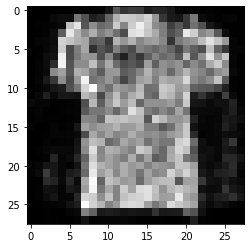

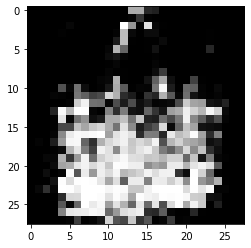

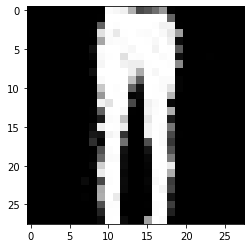

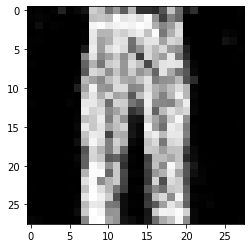

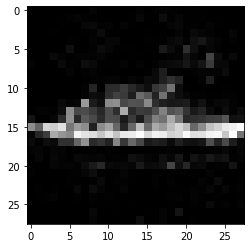

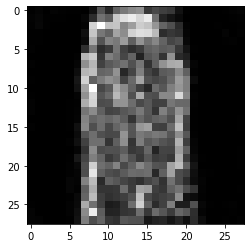

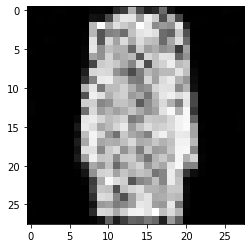

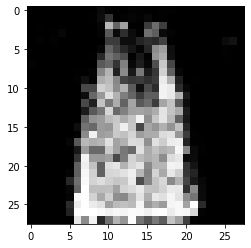

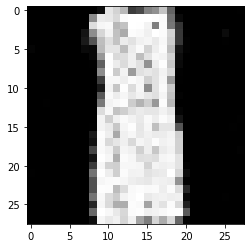

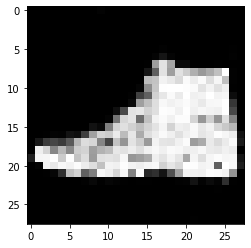

In [31]:
# 생성자가 만든 이미지 시각화
import numpy as np

z = torch.randn(batch_size, 64).to(device)
fake_images = G(z)
for i in range(10):
  fake_images_img = np.reshape(fake_images.data.cpu().numpy()[i], (28,28))
  plt.imshow(fake_images_img, cmap='gray')
  plt.show()